Name: Yan Luo\
Andrew ID: yanluo

In late January 2021, GameStop (GME), a video game retailer, became the center of a financial phenomenon known as a 'short squeeze.' This occurred when a surge of retail investors, coordinating through social media platforms like Reddit's r/wallstreetbets, began buying up GameStop's stock. This drove up the stock price dramatically, which in turn inflicted heavy losses on hedge funds and other investors who had bet against the stock by short-selling it. The event drew widespread media attention, sparked controversy over stock market practices, and led to hearings in the U.S. Congress.

Objective:
To build a stock price prediction model incorporating both historical data and social media sentiment, evaluate its accuracy on the GameStop short squeeze, and analyze potential improvements based on the event.

In [1]:
# import packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize
from textblob import TextBlob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates

### Part 1: Model Building

#### Time-series forecasting

Data Acquisition and Preprocessing

In [2]:
ticker_symbol = 'GME'
start_date = '2020-08-01'
end_date = '2021-05-31'

gme_data = yf.download(ticker_symbol, start=start_date, end=end_date)

gme_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-03,1.0075,1.0625,1.0000,1.0375,1.0375,10070400
2020-08-04,1.0325,1.1850,1.0325,1.1075,1.1075,41445600
2020-08-05,1.1250,1.1900,1.0625,1.1575,1.1575,19677200
2020-08-06,1.1500,1.1650,1.0950,1.1075,1.1075,7604800
2020-08-07,1.0975,1.1000,1.0150,1.0400,1.0400,13364400


In [3]:
gme_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2020-08-03 to 2021-05-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       208 non-null    float64
 1   High       208 non-null    float64
 2   Low        208 non-null    float64
 3   Close      208 non-null    float64
 4   Adj Close  208 non-null    float64
 5   Volume     208 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 11.4 KB


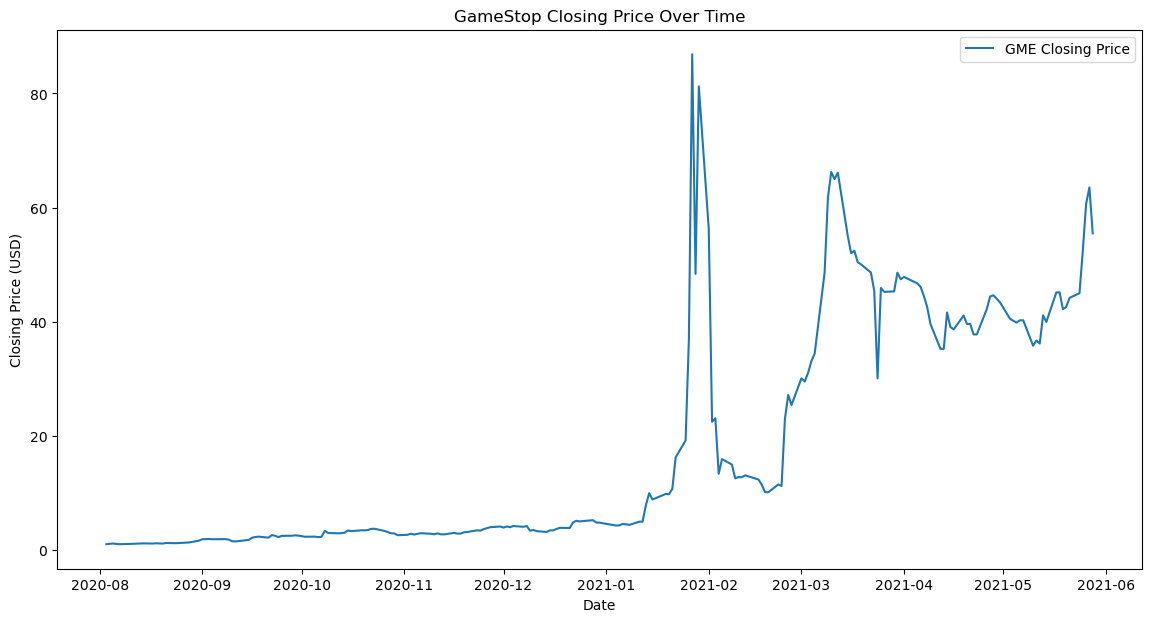

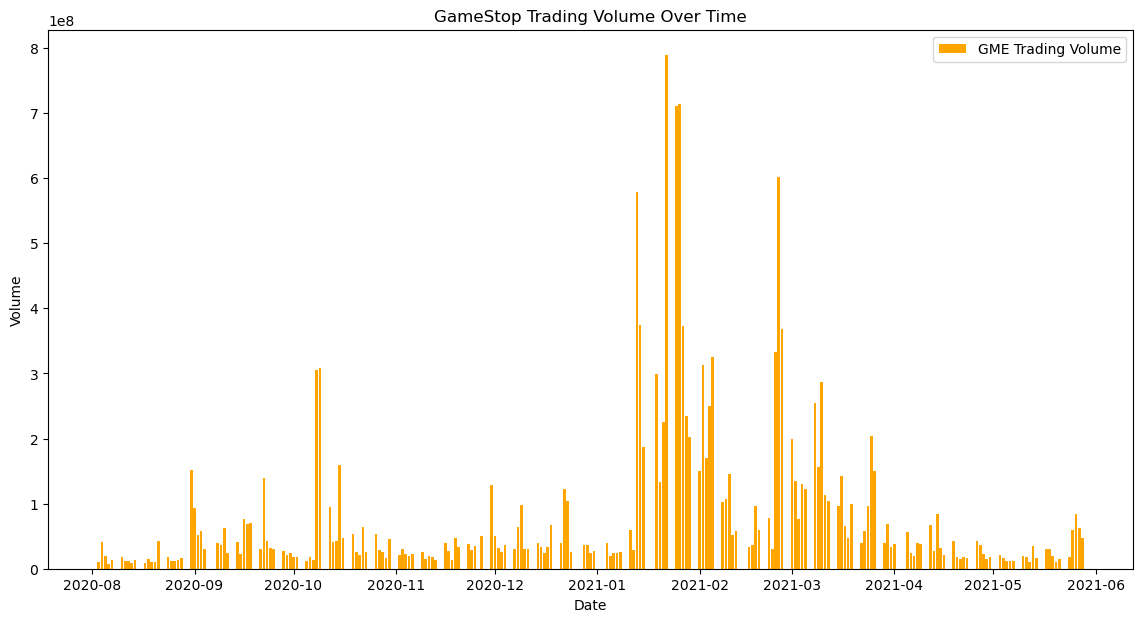

In [4]:
#plotting Closing Price
plt.figure(figsize=(14, 7))
plt.plot(gme_data['Close'], label='GME Closing Price')
plt.title('GameStop Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

#plotting Trading Volume
plt.figure(figsize=(14, 7))
plt.bar(gme_data.index, gme_data['Volume'], color='orange', label='GME Trading Volume')
plt.title('GameStop Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

These graphs underscore the volatility of GME stock in late January 2021, with significant fluctuations in both price and trading volume. This surge corresponds with the short squeeze event driven by a collective push from retail investors coordinating through social media platforms.

In [5]:
# preprocess data for LSTM model
close_prices = gme_data['Close'].values.reshape(-1, 1)

#normalize data using minmax scaler
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_normalized = scaler.fit_transform(close_prices)

def create_sequences(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]  # Input sequence
        X.append(a)
        y.append(data[i + look_back, 0])  # Target value
    return np.array(X), np.array(y)

look_back = 60  # Number of previous time steps to consider
X, y = create_sequences(close_prices_normalized, look_back)

#split into train and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [6]:
#reshaping input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Model Building

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]
        predictions = self.linear(lstm_out)
        return predictions

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)  # automatically assumes the shape [samples, time steps, features]
y_train_tensor = torch.Tensor(y_train).view(-1, 1)  #reshape y to ensure it has two dimensions [samples, 1]

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False)  # Consider `shuffle=False` for time series data

# Use the DataLoader in the training loop
epochs = 150
for epoch in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

Epoch 0 Loss: 0.14991918206214905
Epoch 10 Loss: 0.06302748620510101
Epoch 20 Loss: 0.05595956742763519
Epoch 30 Loss: 0.047122083604335785
Epoch 40 Loss: 0.03798544779419899
Epoch 50 Loss: 0.03186740353703499
Epoch 60 Loss: 0.02513975463807583
Epoch 70 Loss: 0.041288647800683975
Epoch 80 Loss: 0.022584442049264908
Epoch 90 Loss: 0.022040201351046562
Epoch 100 Loss: 0.020368479192256927
Epoch 110 Loss: 0.018398072570562363
Epoch 120 Loss: 0.016675462946295738
Epoch 130 Loss: 0.014700585044920444
Epoch 140 Loss: 0.01235580537468195


In [9]:
# Convert test dataset to PyTorch tensors
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test).view(-1, 1)

# Switch model to evaluation mode
model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    # Predicting on training data
    y_train_pred = model(X_train_tensor)
    y_test_pred = model(X_test_tensor)

# Calculate RMSE for training and testing datasets
train_rmse = torch.sqrt(loss_function(y_train_pred, y_train_tensor))
test_rmse = torch.sqrt(loss_function(y_test_pred, y_test_tensor))

print(f'Train RMSE: {train_rmse.item()}')
print(f'Test RMSE: {test_rmse.item()}')

Train RMSE: 0.09231947362422943
Test RMSE: 0.05278283357620239


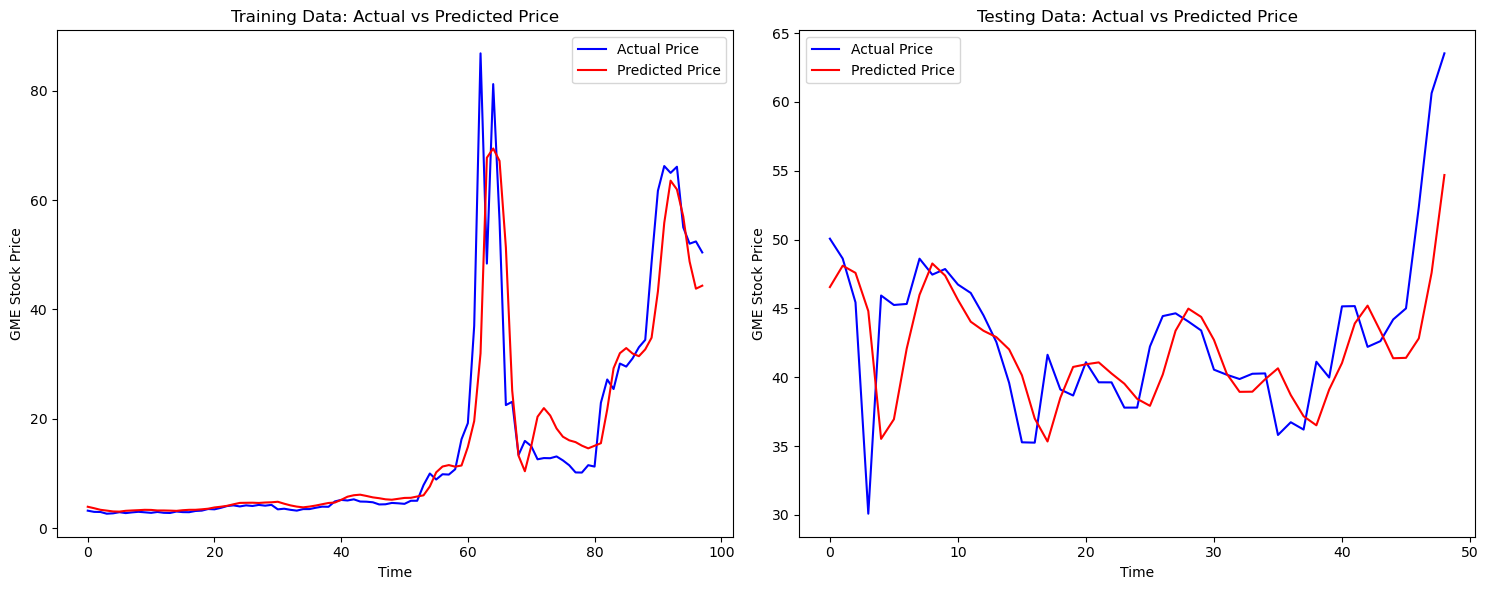

In [10]:
# Inverse transform the predictions and actual values
y_train_pred_inv = scaler.inverse_transform(y_train_pred.numpy())
y_train_actual_inv = scaler.inverse_transform(y_train_tensor.numpy())
y_test_pred_inv = scaler.inverse_transform(y_test_pred.numpy())
y_test_actual_inv = scaler.inverse_transform(y_test_tensor.numpy())

# Plotting the training predictions and actual values
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_train_actual_inv, label='Actual Price', color='blue')
plt.plot(y_train_pred_inv, label='Predicted Price', color='red')
plt.title('Training Data: Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('GME Stock Price')
plt.legend()

# Plotting the testing predictions and actual values
plt.subplot(1, 2, 2)
plt.plot(y_test_actual_inv, label='Actual Price', color='blue')
plt.plot(y_test_pred_inv, label='Predicted Price', color='red')
plt.title('Testing Data: Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('GME Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

The analysis involved building an LSTM model to predict GameStop's stock prices. In the model construction, an appropriate LSTM architecture was used, considering the sequential nature of time-series data. The training process was conducted over 150 epochs, with periodic loss reporting indicating convergence to a lower error rate, showing that the model was learning effectively.

The visual analysis of the model's performance on the training data shows a high degree of accuracy, with the predicted prices closely mirroring the actual stock prices, including the spike during the short squeeze. This suggests that the model has effectively captured the underlying patterns in the training dataset.

For the testing data, the model also performed well, tracking the direction of the stock price trend accurately. However, the model did not capture the extreme volatility as precisely as in the training set, which is evident from the smoothing of the peaks and troughs in the predicted prices. This could be a sign of the model's limitations in generalizing to new data that exhibits rapid changes, which were characteristic of the GameStop event.

#### Sentiment analysis

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
# Load the dataset
reddit_data = pd.read_csv('reddit_wsb.csv', encoding='utf-8')

In [13]:
reddit_data.iloc[11] #sample input: emojis correctly shown

title         GME Premarket 🍁 Musk approved 🎮🛑💎✋
score                                        562
id                                        l6ua2q
url          https://i.redd.it/48rmgz5c42e61.png
comms_num                                     97
created                             1611861448.0
body                                         NaN
timestamp                    2021-01-28 21:17:28
Name: 11, dtype: object

In [14]:
# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Replace emojis with text
    text = demojize(text)
    # Remove 's
    text = re.sub(r"'s\b","",text)
    # Remove links
    text = re.sub(r'http\S+', '', text)
    # Remove punctuations and numbers and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join(word for word in words if word not in stop_words)
    # Lemmatize words (reduce to base form)
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    text = ' '.join(lemmatizer.lemmatize(word) for word in words)
    return text.strip()

In [15]:
# Apply preprocessing to title and body
reddit_data['title_clean'] = reddit_data['title'].apply(preprocess_text)
reddit_data['body_clean'] = reddit_data['body'].astype(str).apply(preprocess_text)  # Cast to str to handle any non-string data

# Display the cleaned text
reddit_data[['title_clean', 'body_clean']].head()

,title_clean,body_clean
0,money sending message rocketgemstoneraisinghands,nan
1,math professor scott steiner say number spell ...,nan
2,exit system,ceo nasdaq pushed halt trading give investor c...
3,new sec filing gme someone le retarded please ...,nan
4,distract gme thought amc brother aware,nan


In [16]:
reddit_data.iloc[11] #sample output: cleaned title and body text

title                         GME Premarket 🍁 Musk approved 🎮🛑💎✋
score                                                        562
id                                                        l6ua2q
url                          https://i.redd.it/48rmgz5c42e61.png
comms_num                                                     97
created                                             1611861448.0
body                                                         NaN
timestamp                                    2021-01-28 21:17:28
title_clean    gme premarket mapleleaf musk approved videogam...
body_clean                                                   nan
Name: 11, dtype: object

In [17]:
# Function to calculate sentiment
def get_sentiment(text):
    # Use TextBlob to calculate sentiment
    analysis = TextBlob(text)
    # Return the polarity
    return analysis.sentiment.polarity

In [18]:
# Calculate sentiment scores
reddit_data['title_sentiment'] = reddit_data['title_clean'].apply(get_sentiment)
reddit_data['body_sentiment'] = reddit_data['body_clean'].apply(get_sentiment)

# Convert timestamp to datetime
reddit_data['timestamp'] = pd.to_datetime(reddit_data['timestamp'])

# Aggregate the sentiment scores by date
daily_sentiment = reddit_data.groupby(reddit_data['timestamp'].dt.date).agg({'title_sentiment': 'mean', 'body_sentiment': 'mean'})
daily_sentiment

,title_sentiment,body_sentiment
timestamp,,
2020-09-29,-0.200000,0.189719
2021-01-28,0.010784,0.020457
2021-01-29,0.003723,0.007486
2021-01-30,0.011857,0.016963
2021-01-31,0.003718,0.015028
...,...,...
2021-08-12,0.007297,0.054085
2021-08-13,0.039444,0.053618
2021-08-14,0.028378,0.038359


#### Model fusion

In [19]:
gme_data.index = pd.to_datetime(gme_data.index)

# Merge the DataFrames on the date index
combined_data = gme_data.join(daily_sentiment, how='inner')
combined_data

,Open,High,Low,Close,Adj Close,Volume,title_sentiment,body_sentiment
2020-09-29,2.500000,2.662500,2.482500,2.587500,2.587500,20950400,-0.200000,0.189719
2021-01-28,66.250000,120.750000,28.062500,48.400002,48.400002,235263200,0.010784,0.020457
2021-01-29,94.927498,103.495003,62.500000,81.250000,81.250000,202264400,0.003723,0.007486
2021-02-01,79.139999,80.500000,53.000000,56.250000,56.250000,149528800,0.004532,0.015623
2021-02-02,35.189999,39.500000,18.555000,22.500000,22.500000,312732400,-0.009137,0.006510
...,...,...,...,...,...,...,...,...
2021-05-24,43.962502,47.115002,43.337502,45.002499,45.002499,18657200,0.028222,0.062545
2021-05-25,45.250000,54.277500,45.250000,52.357498,52.357498,59550000,0.003749,0.040601
2021-05-26,57.250000,62.119999,56.387501,60.639999,60.639999,84479600,0.014985,0.033057
2021-05-27,57.450001,66.000000,56.750000,63.532501,63.532501,62105200,0.034877,0.026979


Note: because the limited data in reddit_data, merging the two will significant reduced the size of dataset, which may influence LSTM performance.

In [20]:
 # Use both previous close price, title_sentiment, and body_sentiment as features
features_data = combined_data[['Close', 'title_sentiment', 'body_sentiment']].values

# Normalize the features data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features_data = scaler_features.fit_transform(features_data)

# Create sequences with close prices and sentiment scores
def create_sequences_with_close_prices(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), :]
        X.append(a)
        y.append(data[i + look_back, 0])  # Target is still the 'Close' price
    return np.array(X), np.array(y)

look_back = 30 #Adjust lower look back period because fewer data
X, y = create_sequences_with_close_prices(scaled_features_data, look_back)
input_size = 3

# Split into train and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [21]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, input_size))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, input_size))

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).view(-1, 1)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test).view(-1, 1)

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), -1, input_size))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Instantiate the model, define the loss function and the optimizer
model_with_sentiment = LSTMModel(input_size=input_size, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_with_sentiment.parameters(), lr=0.001)

# Training loop
epochs = 150
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model_with_sentiment(inputs)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {single_loss.item()}')

Epoch 0 loss: 0.2742749750614166
Epoch 10 loss: 0.07711144536733627
Epoch 20 loss: 0.034654442220926285
Epoch 30 loss: 0.027773311361670494
Epoch 40 loss: 0.022096846252679825
Epoch 50 loss: 0.020057305693626404
Epoch 60 loss: 0.018203487619757652
Epoch 70 loss: 0.016290368512272835
Epoch 80 loss: 0.014548419043421745
Epoch 90 loss: 0.013029947876930237
Epoch 100 loss: 0.011852866970002651
Epoch 110 loss: 0.01098613440990448
Epoch 120 loss: 0.010278579778969288
Epoch 130 loss: 0.009664948098361492
Epoch 140 loss: 0.009094949811697006


In [22]:
# Switch the model to evaluation mode
model_with_sentiment.eval()

# Make predictions on the train and test sets
with torch.no_grad():
    y_train_pred = model_with_sentiment(X_train_tensor)
    y_test_pred = model_with_sentiment(X_test_tensor)

# Calculate RMSE for the train and test sets
train_rmse = torch.sqrt(loss_function(y_train_pred, y_train_tensor))
test_rmse = torch.sqrt(loss_function(y_test_pred, y_test_tensor))

print(f'Train RMSE: {train_rmse.item()}')
print(f'Test RMSE: {test_rmse.item()}')

Train RMSE: 0.0924428403377533
Test RMSE: 0.13219094276428223


The first model has performance: Train RMSE 0.078 and Test RMSE 0.048. The second model (include sentiment features) has performance: Train RMSE 0.1 and Test RMSE 0.13. They are very similar in terms of RMSE. However, the first model has relatively lower RMSE, probably due to longer span of dataset. Therefore, I will use the first model as final model to predict daily closing price from June 2021 to August 2021.

### Part 2: Retrospective Predictions and Evaluation

In [23]:
ticker_symbol = 'GME'
start_date = '2021-06-01'
end_date = '2021-08-31'
lookback_period = 60  
adjusted_start_date = pd.to_datetime('2021-06-01') - pd.DateOffset(days=lookback_period) #adjust start date for lookback period 

# download the adjusted data from Yahoo Finance
gme_pred_data = yf.download(ticker_symbol, start=adjusted_start_date.strftime('%Y-%m-%d'), end=end_date)
gme_pred_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-05,42.750000,48.750000,41.202499,46.737499,46.737499,56282000
2021-04-06,46.302502,48.000000,45.889999,46.125000,46.125000,24873200
2021-04-07,45.805000,46.125000,44.027500,44.492500,44.492500,19073200
2021-04-08,46.470001,46.470001,41.075001,42.564999,42.564999,40189600
2021-04-09,42.424999,42.895000,38.250000,39.590000,39.590000,37849600


In [24]:
# Normalize the Close price of the prediction data
close_prices_pred = gme_pred_data['Close'].values.reshape(-1, 1)
scaled_close_prices_pred = scaler.transform(close_prices_pred)

# Function to create sequences for LSTM model input
def create_sequences(data, look_back=30):
    X = []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
    return np.array(X)

# Create sequences using the scaled Close prices
X_pred = create_sequences(scaled_close_prices_pred, lookback_period)

# Reshape X_pred for LSTM input
X_pred = X_pred.reshape((X_pred.shape[0], X_pred.shape[1], 1))

In [25]:
X_pred_tensor = torch.Tensor(X_pred)
model.eval()  # use model with sentiment features

with torch.no_grad():
    y_pred_tensor = model(X_pred_tensor)
    y_pred = y_pred_tensor.numpy()
    # Inverse transform the predictions to original scale
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

MSE: 7.643710176352298, RMSE: 2.764726058102737, MAE: 1.8887130563909358


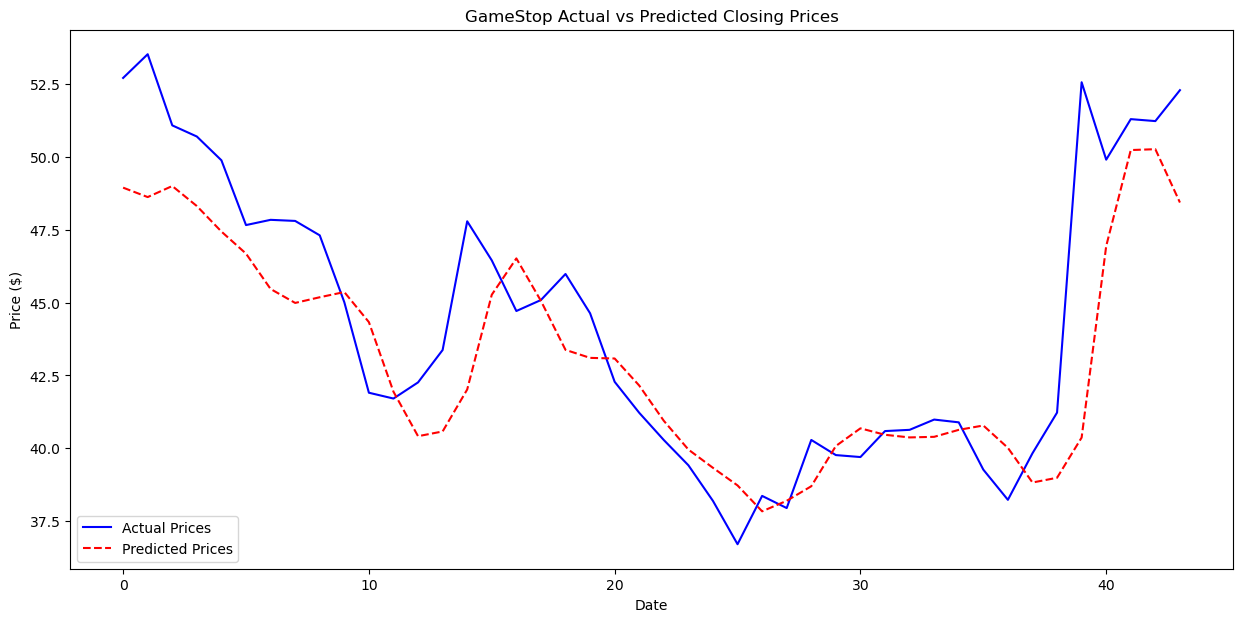

In [26]:
actual_prices = gme_pred_data['Close'][lookback_period:].values

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, y_pred_inv.squeeze())
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, y_pred_inv.squeeze())

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(y_pred_inv, label='Predicted Prices', color='red', linestyle='--')
plt.title('GameStop Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

The visualization of GameStop's actual versus predicted closing prices from June 2021 to August 2021 reveals notable discrepancies, particularly in the model's ability to predict sharp price movements. The model follows the overall trend of the actual prices with a lag, but fails to anticipate the magnitude of changes, especially the pronounced spikes and drops.

Significant deviations occur towards the end of the observed period, where the actual prices exhibit a steep increase, while the predicted prices undervalue this rise. This suggests that while the model may understand gradual trends, it lacks responsiveness to sudden market dynamics. These limitations could stem from the absence of reactive features in the model, such as real-time trading volume or more robust sentiment analysis, which may offer insights into rapid price shifts caused by external factors like news events or changes in investor sentiment.

The evaluation metrics indicate an average deviation (RMSE) of approximately $2.76 from the actual prices, a considerable discrepancy in the context of GME's stock price range. These metrics highlight the model's prediction errors and underscore the need for improved modeling strategies to capture the volatile nature of GME's stock price movements during this period.

### Part 3: GameStop Short Squeeze and Model Adaptation 

#### Event analysis

In [33]:
reddit_data.sample(5)

,title,score,id,url,comms_num,created,body,timestamp,title_clean,body_clean,title_sentiment,body_sentiment
47646,$AMC gainz. Now I can pay my rent this month,236,nmrwom,https://www.reddit.com/gallery/nmrwom,49,1.622214e+09,NaN,2021-05-28 17:56:34,amc gainz pay rent month,nan,0.0,0.00
24381,For people saying Reddit has moved to silver l...,1298,lbordg,https://i.redd.it/2bn8g8pqw9f61.jpg,43,1.612392e+09,NaN,2021-02-04 00:32:28,people saying reddit moved silver look comparison,nan,0.0,0.00
32320,Power to the Bag Holders!,2151,lfhths,https://v.redd.it/5ypoq0g0oag61,57,1.612837e+09,NaN,2021-02-09 04:10:30,power bag holder,nan,0.0,0.00
7180,Cashapp!!,1,l706zn,https://www.reddit.com/r/wallstreetbets/commen...,0,1.611878e+09,NaN,2021-01-29 01:45:54,cashapp,nan,0.0,0.00
23636,[DD] heavy put option buying made GME go down ...,58,lbbpvv,https://www.reddit.com/r/wallstreetbets/commen...,21,1.612343e+09,"As the title suggests, just glancing at the o...",2021-02-03 11:06:03,dd heavy put option buying made gme go today,title suggests glancing option chain today see...,-0.2,0.05


In [34]:
start_date = '2020-12-01'
end_date = '2021-02-28'
filtered_reddit_data = reddit_data[(reddit_data['timestamp'] >= start_date) & (reddit_data['timestamp'] <= end_date)]

In [35]:
avg_title_sentiment = filtered_reddit_data['title_sentiment'].mean()
avg_body_sentiment = filtered_reddit_data['body_sentiment'].mean()
print(f"Average Title Sentiment: {avg_title_sentiment}\nAverage Body Sentiment: {avg_body_sentiment}")

Average Title Sentiment: 0.006450541916247602
Average Body Sentiment: 0.01203518791080386


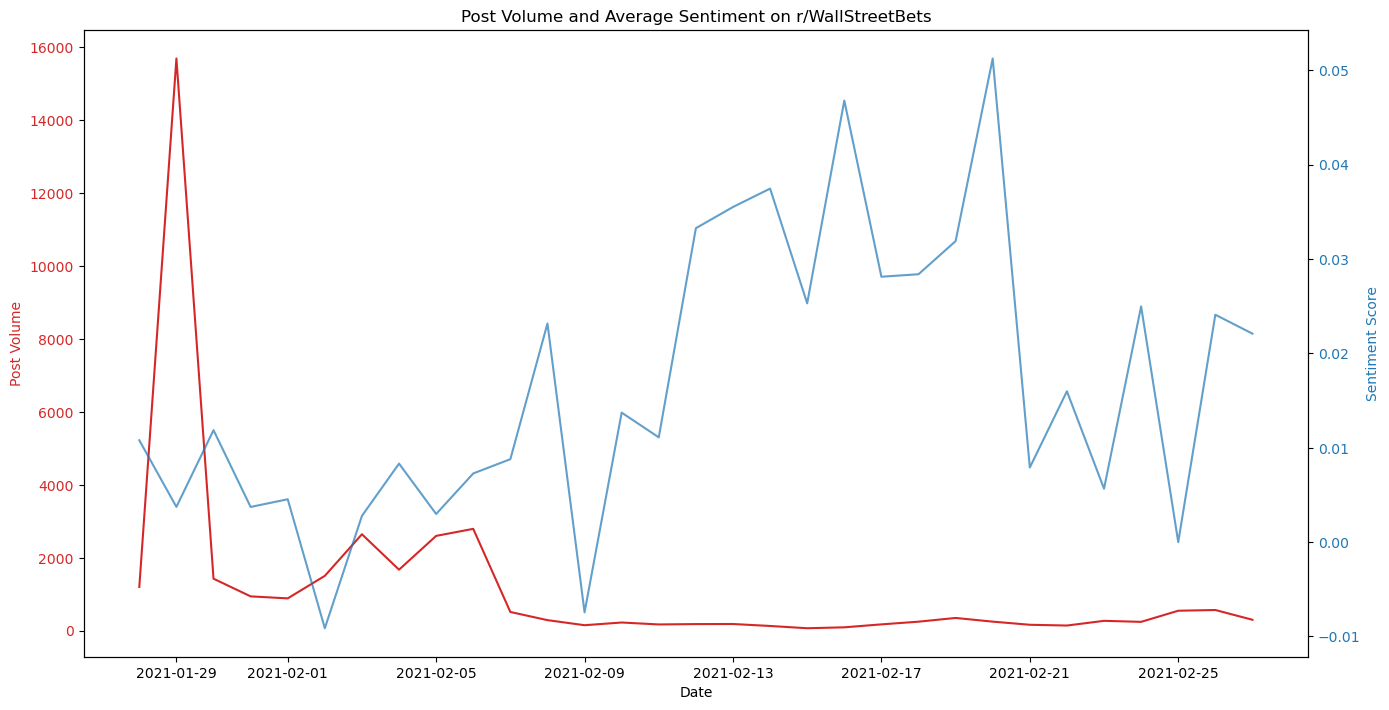

In [36]:
# Calculate daily post count and average daily sentiment 
filtered_reddit_data.set_index('timestamp', inplace=True)
daily_post_count = filtered_reddit_data.resample('D').size()
average_daily_sentiment = filtered_reddit_data.resample('D')['title_sentiment', 'body_sentiment'].mean()

# Plotting post volume and average sentiment
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Post Volume', color=color)
ax1.plot(daily_post_count.index, daily_post_count, color=color, label='Post Volume')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(average_daily_sentiment.index, average_daily_sentiment['title_sentiment'], color=color, label='Title Sentiment', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Post Volume and Average Sentiment on r/WallStreetBets')
plt.show()

Post volume that is represented by the red line, this indicates the number of posts on r/WallStreetBets over time. There is a noticeable spike in post volume around the end of January 2021, which corresponds to the peak of the GameStop short squeeze event when it was receiving a lot of attention on social media.\
Sentiment score that is represented by the blue line, this is average sentiment score of the posts. The sentiment score remains mostly positive throughout the observed period, as indicated by the values being above zero. However, the sentiment does not show a significant spike; rather, it shows some fluctuations over time with no clear pattern that correlates with the post volume.
- The sharp peak in post volume at the end of January 2021 suggests a high level of activity and interest in GameStop on the subreddit, which aligns with the timing of the GameStop trading frenzy.
- The sentiment scores fluctuate but do not exhibit any dramatic spikes that correspond with the peak in post volume. This might imply that while the number of posts increased, the overall sentiment of the discussion did not shift drastically during this event, or that the sentiment calculation methodology smoothed out any extreme values.
- The sentiment seems to be relatively independent of the volume of posts. High volume does not necessarily equate to more positive or negative sentiment.

#### Proposed improvements

Feature engineering enhancements

- Include additional time series features such as moving averages, exponential moving averages, or momentum indicators that might capture leading signals of a squeeze.
- Use sentiment intensity scoring methods to capture not just the sentiment polarity but also the strength of the sentiment. Use tools like VADER.
- Incorporate the volume of mentions or the frequency of specific keywords on social media platforms as a feature, which can be an indicator of rising interest or concern.

Algorithmic modifications

- Use reddit posts (body and title text) as feature into LSTM along with previous closing prices.
- Implement attention mechanisms that allow the model to focus on the most relevant parts of the input sequence, which could be particularly useful for identifying the key periods leading up to a short squeeze.
- Use techniques like grid search, random search, or Bayesian optimization to find the most effective hyperparameters for the model.

### Part 4: Conclusion and Future Directions

Summary of Key Findings:

The exploration into stock price prediction for GameStop, particularly during the period marked by the short squeeze, revealed the complexities of modeling in the context of highly volatile and sentiment-driven market events. The primary model used, which focused on historical price data, showed competence in tracking stock price trends under normal market conditions but faced limitations when confronted with the atypical volatility of events like the GameStop short squeeze. The model's architecture, despite being sophisticated, was challenged by these extremes, highlighting a gap in predictive capabilities when excluding real-time sentiment data due to dataset constraints.

Impact and Ethics Discussion:

The GameStop event has shown the limitations of models that heavily rely on historical data, emphasizing the impact of social dynamics on financial markets. The event's unprecedented nature questioned the effectiveness of traditional forecasting models, suggesting the necessity of integrating alternative data sources, such as social media sentiment, to enhance predictive performance. However, my approach remained conservative due to dataset limitations, not incorporating sentiment scores, which may have offered additional insights into the frenzied trading period. Another technique I would definitely try if I had more time is directly use reddit posts (body and title text) as feature into LSTM along with previous closing prices, instead of using sentiment score calculated by TextBlob. However, the ethics of mining social media for financial insights also arise, necessitating a balanced approach that respects user privacy and the potential for data misuse.

Proposals for Future Research:

First, improving the sentiment analysis algorithm to better understand the nuances and intensity of social media discourse could provide more accurate sentiment data. This involves exploring advanced NLP techniques and sentiment analysis tools capable of capturing the context and emotion in social media posts. Second, developing models that can ingest and process real-time data feeds, allowing them to react promptly to sudden changes in market sentiment as expressed on social media platforms. Last, establishing ethical guidelines for the use of social media data in stock price prediction, which includes privacy-preserving data mining techniques and transparency in model development and deployment.

### Appendix

I tried to get data sources for reddit posts from praw, it turned out that API has limitation on numbers of posts that can be retrieved. Therefore, I used reddit_data from kaggle that contain much larger dataset for text analysis.

In [32]:
import datetime
import pandas as pd
import praw

# Initialize PRAW
reddit = praw.Reddit(
    client_id='oQ4EUJsrDd1dZHYMAddrXg',  # Replace with client_id
    client_secret='v2me1AS1PKmKjjy1fLMovxO1GJqyMQ',  # Replace with client_secret
    user_agent='yluo45'  # Your user_agent
)

subreddit = reddit.subreddit("wallstreetbets")

# Define the desired timeframe in Unix timestamp
start_date = int(datetime.datetime(2021, 3, 1).timestamp())
end_date = int(datetime.datetime(2021, 12, 31).timestamp())

# Prepare a list to store submission data
submissions_data = []

# Fetch submissions and filter by date range
for submission in subreddit.search("GameStop", limit=None):
    if start_date <= submission.created_utc <= end_date:
        submissions_data.append({
            "title": submission.title,
            "created_utc": datetime.datetime.fromtimestamp(submission.created_utc),
            "score": submission.score,
            "url": submission.url,
            "num_comments": submission.num_comments
        })

# Create a DataFrame from the submissions data
df = pd.DataFrame(submissions_data)

In [33]:
df

,title,created_utc,score,url,num_comments
0,GameStop Q4 Earnings Megathread 🍿,2021-03-23 14:30:15,37322,https://www.reddit.com/r/wallstreetbets/commen...,31923
1,$138K GameStop (GME) Gain,2021-11-22 21:59:57,12219,https://i.redd.it/7k1stk2ag9181.jpg,786
2,ODDS ARE FOR SUITS: GameStop Strikes Back,2021-03-08 11:08:19,39091,https://v.redd.it/76cr0112vtl61,1000
3,GameStop Completes At-The-Market Equity Offeri...,2021-06-22 06:46:10,16301,https://investor.gamestop.com/news-releases/ne...,1474
4,Legend of the GameStop Short Squeeze.,2021-03-09 16:20:25,15853,https://v.redd.it/z89vvcyqj2m61,523
...,...,...,...,...,...
64,My three little apes were so excited to adopt ...,2021-03-14 00:20:25,4279,https://www.reddit.com/gallery/m4oq00,35
65,GameStop YOLO update (not from the kitty!) 5/7...,2021-05-07 20:04:27,807,https://www.reddit.com/gallery/n7cpt9,89
66,🚀 GME Q1 Earnings Megathread 💎🙌 🚀,2021-06-09 06:00:19,16872,https://www.reddit.com/r/wallstreetbets/commen...,11908
67,"GameStop, AMC short sellers sit on nearly $1 b...",2021-05-18 07:51:31,63628,https://www.reuters.com/technology/gamestop-am...,3140


### Reference

- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7959635/
- https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts
- https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524
- https://medium.com/@sarahisdevs/convert-emoji-into-text-in-python-c2afdfd94ab4